In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!apt-get update -qq
!apt-get install fonts-nanum* -qq

!pip install kaggle
!pip install -q ultralytics pycocotools easyocr opencv-python pillow matplotlib tqdm scikit-image
!pip install rembg
!pip install onnxruntime onnxruntime-gpu

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (18.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126455 files and direc

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)

fm.fontManager.addfont(path)

In [4]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_USERNAME'] = 'starsin'
os.environ['KAGGLE_KEY'] = 'ff559a02afd29d67f19bc4001d5a69f7'

api = KaggleApi()
api.authenticate()


# 2. 대회 데이터 다운로드
competition_name = "ai05-level1-project"
api.competition_download_files(competition_name, path="./data")

In [5]:
import zipfile

zip_path = "./data/ai05-level1-project.zip"
extract_dir = "./data/ai05-level1-project"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

In [6]:
# === Cell 1: 공통 설정 & 유틸 ===
import os, json, math, shutil, random, glob
from pathlib import Path
from collections import defaultdict, Counter
from typing import List, Dict, Tuple
from PIL import Image
import pandas as pd
import numpy as np

# ---- 경로 설정 (환경에 맞게 조정) ----
DATA_ROOT      = "./data/ai05-level1-project"
TRAIN_IMG_DIR  = f"{DATA_ROOT}/train_images"
TEST_IMG_DIR   = f"{DATA_ROOT}/test_images"
ANN_DIR        = f"{DATA_ROOT}/train_annotations"   # *_json 폴더 구조
WORK_DIR       = "./work_yolov8"

ALL_JSON       = f"{WORK_DIR}/all.json"             # 병합 COCO
CLEAN_JSON     = f"{WORK_DIR}/all_clean.json"       # 클린 COCO
KFOLD_DIR      = f"{WORK_DIR}/kfold"                # 폴드 COCO 저장
YOLO_ROOT      = f"{WORK_DIR}/yolo_splits"          # 폴드별 YOLO 데이터셋
PRED_DIR       = f"{WORK_DIR}/predictions"

os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(KFOLD_DIR, exist_ok=True)
os.makedirs(YOLO_ROOT, exist_ok=True)
os.makedirs(PRED_DIR, exist_ok=True)

# ---- 파라미터(필요시 조정) ----
SEED                    = 42
random.seed(SEED); np.random.seed(SEED)
N_FOLDS                 = 5
K_PER_CLASS_IN_VAL      = 1    # 각 클래스 최소 커버
MIN_BBOX_WH             = 2    # bbox 최소 너비/높이 (px)
MAX_IMAGE_COVER_RATIO   = 0.95 # 박스가 이미지 95% 이상이면 제거
DEDUP_ROUND_DIGITS      = 1    # 중복판정 소수점 자리
IMG_EXTS                = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

def image_size_from_disk(file_name: str) -> Tuple[int,int]:
    p = os.path.join(TRAIN_IMG_DIR, file_name)
    if not os.path.isfile(p): return (0,0)
    try:
        with Image.open(p) as im:
            return im.size
    except:
        return (0,0)

def is_image_missing(file_name: str) -> bool:
    return not os.path.isfile(os.path.join(TRAIN_IMG_DIR, file_name))

def clip_bbox(x,y,w,h,W,H):
    if any(v is None for v in [x,y,w,h]): return None
    if w <= 0 or h <= 0: return None
    x = max(0, min(float(x), max(0, W-1)))
    y = max(0, min(float(y), max(0, H-1)))
    w = max(float(MIN_BBOX_WH), min(float(w), max(1.0, W - x)))
    h = max(float(MIN_BBOX_WH), min(float(h), max(1.0, H - y)))
    if (w*h) > (MAX_IMAGE_COVER_RATIO * W * H):
        return None
    return [float(x), float(y), float(w), float(h)]

def ann_key(img_id, cat_id, bbox, digits=DEDUP_ROUND_DIGITS):
    x,y,w,h = [round(float(v), digits) for v in bbox]
    return f"{int(img_id)}_{int(cat_id)}_{x}_{y}_{w}_{h}"

def load_coco(path: str) -> Dict:
    with open(path, "r", encoding="utf-8") as f:
        d = json.load(f)
    for k in ["images","annotations","categories"]:
        assert k in d, f"COCO key missing: {k}"
    return d

def save_coco(d: Dict, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(d, f, ensure_ascii=False, indent=2)

def ensure_min_class_coverage(val_img_ids: set, img_to_cats: Dict[int,set], target_min=1) -> set:
    class_to_imgs_val = defaultdict(set)
    for iid in val_img_ids:
        for c in img_to_cats.get(iid, set()):
            class_to_imgs_val[c].add(iid)

    need = {}
    all_classes = set()
    for s in img_to_cats.values(): all_classes |= s
    for c in all_classes:
        cur = len(class_to_imgs_val.get(c, set()))
        if cur < target_min:
            need[c] = target_min - cur

    if not need: return val_img_ids

    all_img_ids = set(img_to_cats.keys())
    train_pool = list(all_img_ids - set(val_img_ids))
    random.shuffle(train_pool)

    for c, deficit in need.items():
        if deficit <= 0: continue
        for iid in train_pool:
            if iid in val_img_ids: continue
            if c in img_to_cats.get(iid, set()):
                val_img_ids.add(iid)
                deficit -= 1
                if deficit <= 0: break

    return val_img_ids

In [8]:
# === Cell: 어노테이션 및 카테고리 병합 ===
import os, json
from pathlib import Path
from collections import defaultdict
from PIL import Image

# === 설정 ===
ANN_DIR = "./data/ai05-level1-project/train_annotations"              # 폴더별 *_json 구조가 있는 곳
TRAIN_IMG_DIR = "./data/ai05-level1-project/train_images"
ALL_JSON = "./work_yolov8/all.json"

os.makedirs(os.path.dirname(ALL_JSON), exist_ok=True)

# === 유틸 ===
def file_exists_in_train_images(fn):
    return os.path.isfile(os.path.join(TRAIN_IMG_DIR, fn))

def norm_name(fn: str):
    return Path(fn).name.strip().replace("\\", "/")

def get_img_size_from_disk(fn):
    p = os.path.join(TRAIN_IMG_DIR, fn)
    if not os.path.isfile(p):
        return (0, 0)
    try:
        with Image.open(p) as im:
            return im.size
    except:
        return (0, 0)

def bbox_valid_clip(x, y, w, h, W, H):
    """잘못된 bbox 제거 + 이미지 범위 내로 클램핑"""
    if any(v is None for v in [x, y, w, h]): return None
    if w <= 0 or h <= 0: return None
    x = max(0, min(x, W-1))
    y = max(0, min(y, H-1))
    w = max(1, min(w, W-x))
    h = max(1, min(h, H-y))
    return [float(x), float(y), float(w), float(h)]

def hash_cat(c):
    """카테고리 중복 판단용 간단한 해시"""
    return f"{c.get('name','').strip().lower()}|{c.get('supercategory','').strip().lower()}"

def dedup_key(img_id, cat_id, bbox):
    """annotation 중복 방지 키"""
    return f"{img_id}_{cat_id}_{round(bbox[0],1)}_{round(bbox[1],1)}_{round(bbox[2],1)}_{round(bbox[3],1)}"

# === 메인 병합 ===
merged = {"images": [], "annotations": [], "categories": []}
cat_by_hash, cat_id_map = {}, {}
file_to_new_img_id, image_meta = {}, {}
seen_ann_keys = set()

new_img_id, ann_id, new_cat_id = 1, 1, 1
cnt = defaultdict(int)

for folder in sorted(os.listdir(ANN_DIR)):
    if not folder.endswith("_json"):
        continue
    cnt["folders_scanned"] += 1
    for dp, _, files in os.walk(os.path.join(ANN_DIR, folder)):
        for f in files:
            if not f.lower().endswith(".json"):
                continue
            cnt["json_scanned"] += 1
            jp = os.path.join(dp, f)
            try:
                j = json.load(open(jp, "r", encoding="utf-8"))
            except Exception:
                continue

            # === 1) 카테고리 병합 ===
            for c in j.get("categories", []):
                h = hash_cat(c)
                cid = int(c["id"])
                if h not in cat_by_hash:
                    cat_by_hash[h] = {"id": cid, "name": c.get("name", ""), "supercategory": c.get("supercategory", "pill")}
                cat_id_map[c["id"]] = cat_by_hash[h]["id"]

            # === 2) 이미지 및 어노테이션 병합 ===
            for im in j.get("images", []):
                file_name = norm_name(im.get("file_name", ""))
                if not file_exists_in_train_images(file_name):
                    continue
                if file_name not in file_to_new_img_id:
                    W, H = get_img_size_from_disk(file_name)
                    if W == 0 or H == 0:
                        continue
                    file_to_new_img_id[file_name] = new_img_id
                    image_meta[new_img_id] = {
                        "id": new_img_id,
                        "file_name": file_name,
                        "width": W,
                        "height": H,
                    }
                    new_img_id += 1

            for a in j.get("annotations", []):
                src_im = next((im for im in j.get("images", []) if im["id"] == a.get("image_id")), None)
                if not src_im:
                    continue
                file_name = norm_name(src_im.get("file_name", ""))
                if file_name not in file_to_new_img_id:
                    continue
                W, H = get_img_size_from_disk(file_name)
                fixed = bbox_valid_clip(*a["bbox"], W, H)
                if not fixed:
                    continue
                new_imgid = file_to_new_img_id[file_name]
                new_catid = cat_id_map.get(a["category_id"], 1)

                k = dedup_key(new_imgid, new_catid, fixed)
                if k in seen_ann_keys:
                    continue
                seen_ann_keys.add(k)

                merged["annotations"].append({
                    "id": ann_id,
                    "image_id": new_imgid,
                    "category_id": new_catid,
                    "bbox": fixed,
                    "area": float(fixed[2] * fixed[3]),
                    "iscrowd": int(a.get("iscrowd", 0))
                })
                ann_id += 1

merged["images"] = [image_meta[i] for i in sorted(image_meta)]
merged["categories"] = [cat_by_hash[h] for h in sorted(cat_by_hash)]

json.dump(merged, open(ALL_JSON, "w"), indent=2, ensure_ascii=False)
print(f"✅ 병합 완료: {len(merged['images'])} imgs, {len(merged['annotations'])} anns, {len(merged['categories'])} cats")

✅ 병합 완료: 1489 imgs, 4526 anns, 73 cats


In [11]:
# === Cell 0: Imports & Paths ===
import os, json, math, random, glob
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 이미 전 셀에서 정의됐다면 그대로 사용하고, 없으면 기본값 사용
CLEAN_JSON     = globals().get("CLEAN_JSON", "./work_yolov8/all.json")
TRAIN_IMG_DIR  = globals().get("TRAIN_IMG_DIR", "./data/ai05-level1-project/train_images")
IMG_EXTS       = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
SEED           = 42
random.seed(SEED)
np.random.seed(SEED)

assert os.path.isfile(ALL_JSON), f"CLEAN_JSON not found: {ALL_JSON}"
assert os.path.isdir(TRAIN_IMG_DIR), f"TRAIN_IMG_DIR not found: {TRAIN_IMG_DIR}"

def load_coco(p):
    with open(p, "r", encoding="utf-8") as f:
        d = json.load(f)
    for k in ["images","annotations","categories"]:
        if k not in d:
            raise ValueError(f"bad COCO (missing {k}): {p}")
    return d

def image_size_from_disk(img_dir, fname):
    p = os.path.join(img_dir, Path(fname).name)
    if not os.path.isfile(p):
        return (0,0)
    try:
        with Image.open(p) as im:
            return im.size
    except:
        return (0,0)

coco = load_coco(ALL_JSON)

# id 매핑
img_by_id = {im["id"]: im for im in coco["images"]}
cat_by_id = {c["id"]: c for c in coco["categories"]}
cat_names = {cid: cat_by_id[cid].get("name", str(cid)) for cid in cat_by_id}

print(f"📦 images={len(coco['images'])}, anns={len(coco['annotations'])}, cats={len(coco['categories'])}")

📦 images=1489, anns=4526, cats=73


## 기본 분포(이미지/어노/카테고리) 테이블

In [12]:
# === Cell 1: Summary tables ===
# 이미지별 어노 개수
ann_per_img = Counter(a["image_id"] for a in coco["annotations"])

# 카테고리별 어노 개수
ann_per_cat = Counter(int(a["category_id"]) for a in coco["annotations"])

df_img = pd.DataFrame(
    [{"image_id": im["id"], "file_name": Path(im["file_name"]).name,
      "width": im.get("width", None), "height": im.get("height", None),
      "ann_count": ann_per_img.get(im["id"], 0)} for im in coco["images"]]
).sort_values("ann_count", ascending=False)

df_cat = pd.DataFrame(
    [{"category_id": cid, "name": cat_names.get(cid, str(cid)), "ann_count": ann_per_cat.get(cid, 0)}
     for cid in sorted(cat_by_id)]
).sort_values("ann_count", ascending=False)

display(df_img.head(10))
display(df_cat.head(20))
print("✅ df_img.shape:", df_img.shape, "| df_cat.shape:", df_cat.shape)

,image_id,file_name,width,height,ann_count
1483,1484,K-003544-012247-016548-021026_0_2_0_2_70_000_2...,976,1280,4
1470,1471,K-003544-010221-016551-027926_0_2_0_2_90_000_2...,976,1280,4
28,29,K-001900-016548-019607-027926_0_2_0_2_90_000_2...,976,1280,4
30,31,K-001900-016548-019607-029345_0_2_0_2_90_000_2...,976,1280,4
31,32,K-001900-016548-019607-029345_0_2_0_2_75_000_2...,976,1280,4
1458,1459,K-003544-010221-016548-029451_0_2_0_2_70_000_2...,976,1280,4
1462,1463,K-003544-010221-016548-033009_0_2_0_2_75_000_2...,976,1280,4
1469,1470,K-003544-010221-016551-027926_0_2_0_2_75_000_2...,976,1280,4
40,41,K-001900-016548-019607-033009_0_2_0_2_90_000_2...,976,1280,4
41,42,K-001900-016548-019607-033009_0_2_0_2_70_000_2...,976,1280,4


,category_id,name,ann_count
3,3482,기넥신에프정(은행엽엑스)(수출용),514
2,3350,일양하이트린정 2mg,240
0,1899,보령부스파정 5mg,180
1,2482,뮤테란캡슐 100mg,172
22,16547,가바토파정 100mg,143
23,16550,동아가바펜틴정 800mg,139
68,35205,아토젯정 10/40mg,113
56,29666,리바로정 4mg,111
20,16231,리피토정 20mg,109
21,16261,크레스토정 20mg,108


✅ df_img.shape: (1489, 5) | df_cat.shape: (73, 3)


## 클래스 불균형 히스토그램

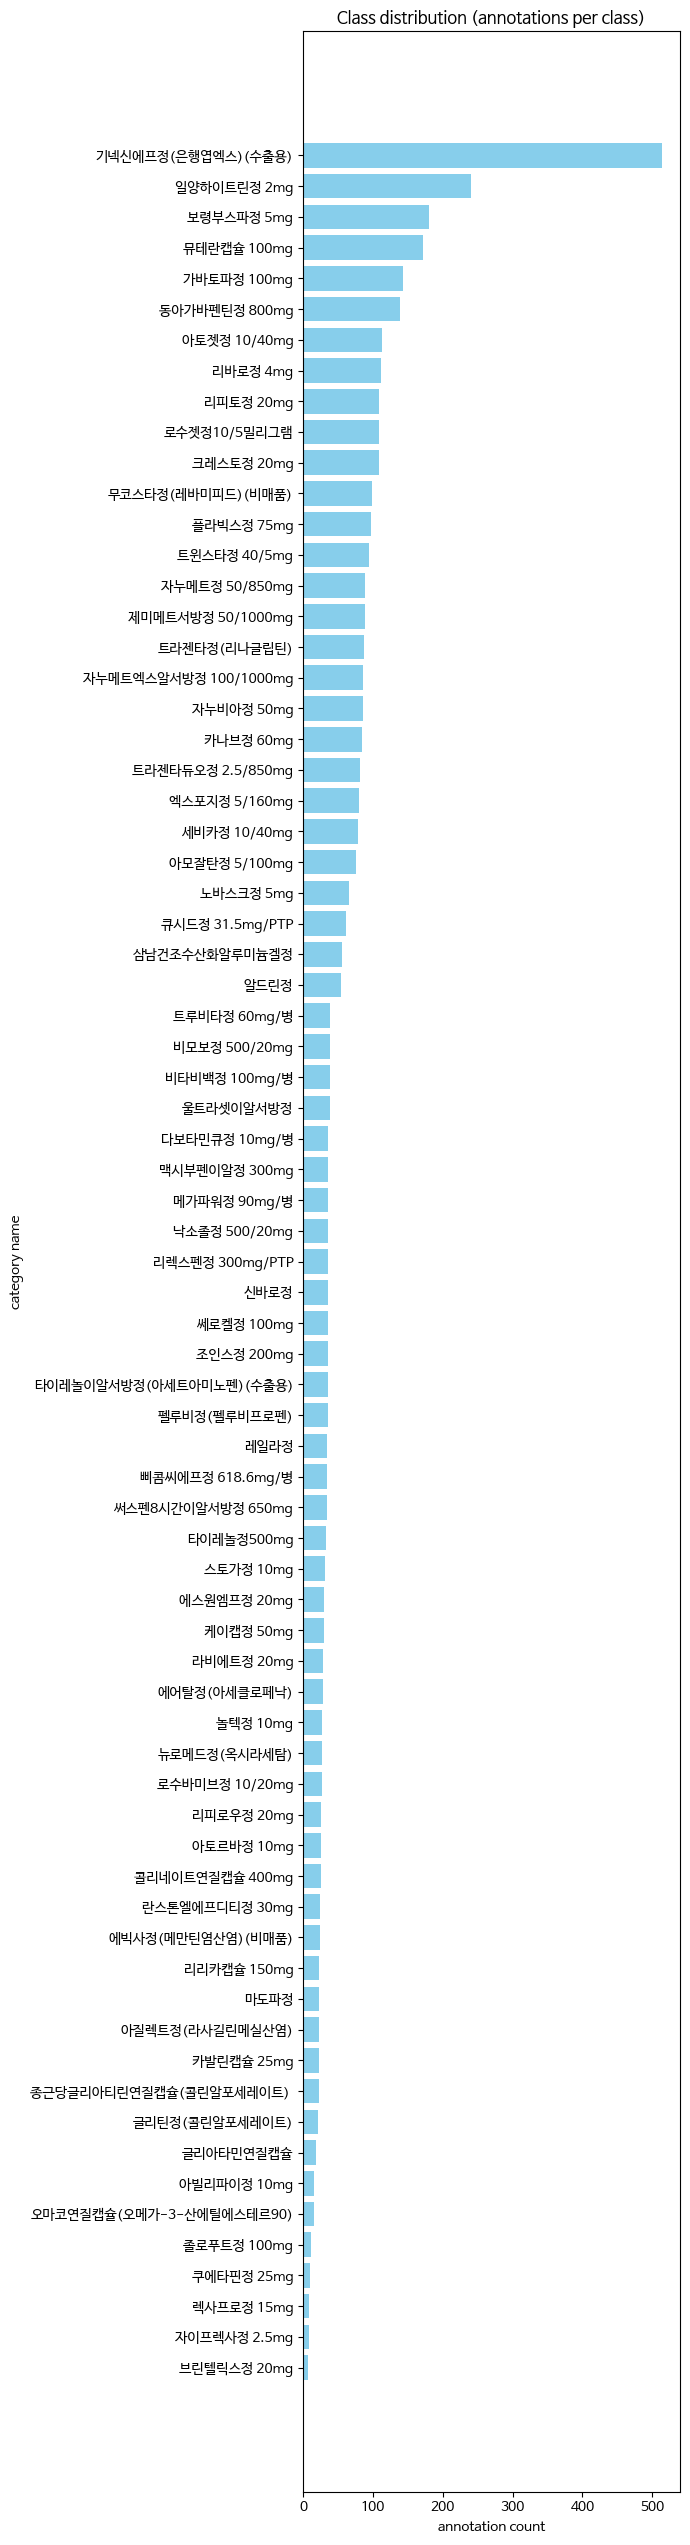

클래스 수: 73 | 최다 클래스: 기넥신에프정(은행엽엑스)(수출용) 514


In [19]:
# === Cell 2: Class histogram (세로형 바차트) ===
labels = [int(a["category_id"]) for a in coco["annotations"]]
names  = [cat_names.get(cid, str(cid)) for cid in labels]

# 카테고리 id 순서 정렬
unique_ids = sorted(cat_by_id.keys(), key=lambda x: ann_per_cat.get(x,0), reverse=True)
x = np.arange(len(unique_ids))
y = [ann_per_cat.get(cid, 0) for cid in unique_ids]
xlabels = [cat_names.get(cid, str(cid)) for cid in unique_ids]

plt.figure(figsize=(7, max(5, len(unique_ids) * 0.35)))  # 세로로 공간 확보
plt.barh(x, y, color='skyblue')
plt.yticks(x, xlabels)
plt.xlabel("annotation count")
plt.ylabel("category name")
plt.title("Class distribution (annotations per class)")
plt.gca().invert_yaxis()  # 큰 클래스가 위로 오게
plt.tight_layout()
plt.show()

print("클래스 수:", len(unique_ids), "| 최다 클래스:", xlabels[0], y[0])

## BBox 크기/비율 분포 (절대 & 정규화)

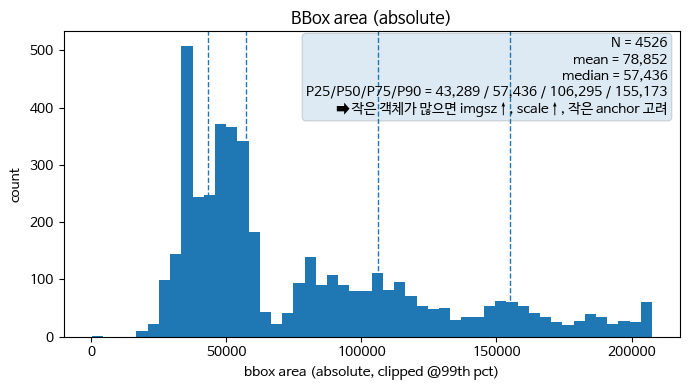

In [20]:
# === Cell 3 (Annotated): BBox size & aspect ratio distributions with on-plot insights ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# df_bbox가 이미 만들어져 있다고 가정
# df_bbox.columns = ["category_id","area_abs","area_rel","ar_box","w","h","W","H"]

def _pct(v, p):
    return float(np.percentile(v, p)) if len(v) else np.nan

def _annot_stats(ax, title, stats_lines):
    """오른쪽 위에 요약 텍스트 상자 표시"""
    txt = "\n".join(stats_lines)
    ax.text(
        0.98, 0.98, txt,
        ha="right", va="top", transform=ax.transAxes,
        bbox=dict(boxstyle="round", alpha=0.15, linewidth=0.8)
    )
    ax.set_title(title)

# -----------------------------
# 1) 절대 면적 분포 (area_abs)
# -----------------------------
abs_vals = df_bbox["area_abs"].to_numpy()
abs_clip = np.clip(abs_vals, a_min=None, a_max=_pct(abs_vals, 99))  # 꼬리 1% 클리핑

p25_abs, p50_abs, p75_abs, p90_abs = [_pct(abs_vals, p) for p in (25,50,75,90)]
mean_abs, med_abs = float(np.mean(abs_vals)), float(np.median(abs_vals))
n_abs = len(abs_vals)

plt.figure(figsize=(7, 4))
ax1 = plt.gca()
ax1.hist(abs_clip, bins=50)
for v, lab in [(p25_abs,"P25"), (p50_abs,"P50"), (p75_abs,"P75"), (p90_abs,"P90")]:
    ax1.axvline(v, linestyle="--", linewidth=1.0)
ax1.set_xlabel("bbox area (absolute, clipped @99th pct)")
ax1.set_ylabel("count")

_annot_stats(
    ax1,
    "BBox area (absolute)",
    [
        f"N = {n_abs}",
        f"mean = {mean_abs:,.0f}",
        f"median = {med_abs:,.0f}",
        f"P25/P50/P75/P90 = {p25_abs:,.0f} / {p50_abs:,.0f} / {p75_abs:,.0f} / {p90_abs:,.0f}",
        "➡ 작은 객체가 많으면 imgsz↑, scale↑, 작은 anchor 고려"
    ]
)
plt.tight_layout()
plt.show()

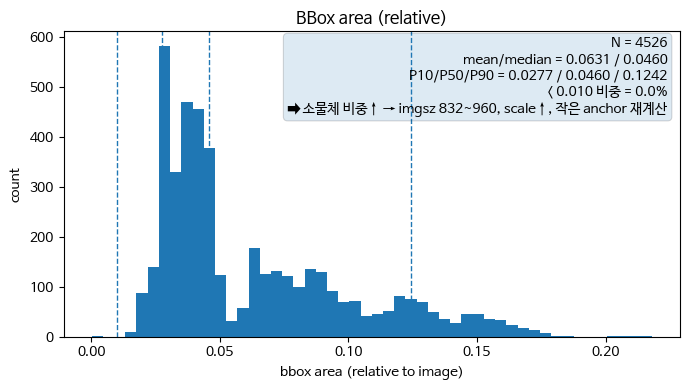

In [21]:

# -----------------------------
# 2) 정규화 면적 분포 (area_rel)
# -----------------------------
rel_vals = df_bbox["area_rel"].to_numpy()
p01_rel, p10_rel, p50_rel, p90_rel = [_pct(rel_vals, p) for p in (1,10,50,90)]
mean_rel, med_rel = float(np.mean(rel_vals)), float(np.median(rel_vals))
n_rel = len(rel_vals)

# 소물체(예시): 0.01(=1%)를 기준선으로 함께 표시
small_thr = 0.01

plt.figure(figsize=(7, 4))
ax2 = plt.gca()
ax2.hist(rel_vals, bins=50)
for v, lab in [(small_thr,"small~"), (p10_rel,"P10"), (p50_rel,"P50"), (p90_rel,"P90")]:
    ax2.axvline(v, linestyle="--", linewidth=1.0)
ax2.set_xlabel("bbox area (relative to image)")
ax2.set_ylabel("count")

small_ratio = float((rel_vals < small_thr).mean()*100.0)
_annot_stats(
    ax2,
    "BBox area (relative)",
    [
        f"N = {n_rel}",
        f"mean/median = {mean_rel:.4f} / {med_rel:.4f}",
        f"P10/P50/P90 = {p10_rel:.4f} / {p50_rel:.4f} / {p90_rel:.4f}",
        f"< {small_thr:.3f} 비중 = {small_ratio:.1f}%",
        "➡ 소물체 비중↑ → imgsz 832~960, scale↑, 작은 anchor 재계산"
    ]
)
plt.tight_layout()
plt.show()

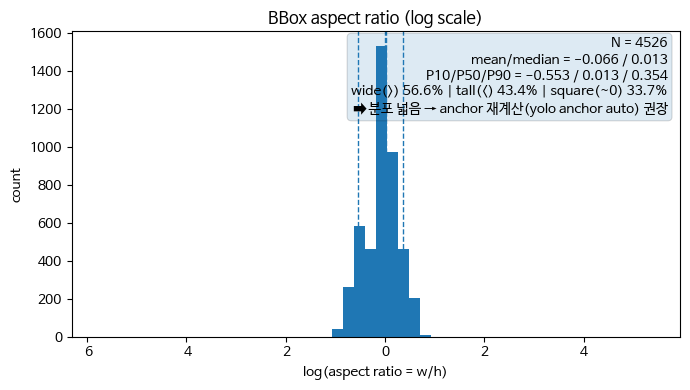

In [23]:
# -----------------------------
# 3) 종횡비 분포 (log(ar = w/h))
# -----------------------------
ar_vals = df_bbox["ar_box"].replace([np.inf, -np.inf], np.nan).dropna().to_numpy()
log_ar = np.log(ar_vals + 1e-12)
p10_lar, p50_lar, p90_lar = [_pct(log_ar, p) for p in (10,50,90)]
mean_lar, med_lar = float(np.mean(log_ar)), float(np.median(log_ar))
n_ar = len(log_ar)

plt.figure(figsize=(7, 4))
ax3 = plt.gca()
ax3.hist(log_ar, bins=50)
for v, lab in [(0.0,"square"), (p10_lar,"P10"), (p50_lar,"P50"), (p90_lar,"P90")]:
    ax3.axvline(v, linestyle="--", linewidth=1.0)
ax3.set_xlabel("log(aspect ratio = w/h)")
ax3.set_ylabel("count")

# 해석용 텍스트: 0보다 크면 가로로 긴 경향, 0보다 작으면 세로로 긴 경향
share_wide  = float((log_ar >  0).mean()*100.0)
share_tall  = float((log_ar <  0).mean()*100.0)
share_sq    = float((np.abs(log_ar) < 0.05).mean()*100.0)  # 거의 정사각

_annot_stats(
    ax3,
    "BBox aspect ratio (log scale)",
    [
        f"N = {n_ar}",
        f"mean/median = {mean_lar:.3f} / {med_lar:.3f}",
        f"P10/P50/P90 = {p10_lar:.3f} / {p50_lar:.3f} / {p90_lar:.3f}",
        f"wide(>) {share_wide:.1f}% | tall(<) {share_tall:.1f}% | square(~0) {share_sq:.1f}%",
        "➡ 분포 넓음 → anchor 재계산(yolo anchor auto) 권장"
    ]
)
plt.tight_layout()
plt.show()

 ## 클래스별 박스 크기 통계(소·중·대 비율)

bucket,large,medium,small,total,small%,medium%,large%
name,,,,,,,
동아가바펜틴정 800mg,139,0,0,139,0.0,0.00,100.00
자누메트정 50/850mg,88,0,0,88,0.0,0.00,100.00
제미메트서방정 50/1000mg,88,0,0,88,0.0,0.00,100.00
자누메트엑스알서방정 100/1000mg,85,0,0,85,0.0,0.00,100.00
트라젠타듀오정 2.5/850mg,81,0,0,81,0.0,0.00,100.00
트루비타정 60mg/병,39,0,0,39,0.0,0.00,100.00
비타비백정 100mg/병,38,0,0,38,0.0,0.00,100.00
다보타민큐정 10mg/병,36,0,0,36,0.0,0.00,100.00
메가파워정 90mg/병,36,0,0,36,0.0,0.00,100.00


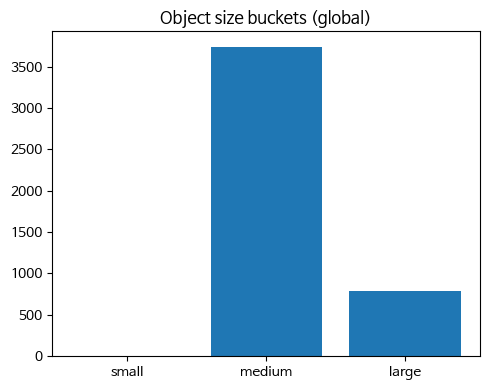

In [16]:
# === Cell 5: Small/Medium/Large split by class ===
def bucket(area_rel):
    if area_rel < 0.01:
        return "small"
    elif area_rel < 0.1:
        return "medium"
    else:
        return "large"

df_bbox["bucket"] = df_bbox["area_rel"].apply(bucket)

pivot = (
    df_bbox.assign(name=df_bbox["category_id"].map(lambda x: cat_names.get(x, str(x))))
           .pivot_table(index="name", columns="bucket", values="area_rel", aggfunc="count", fill_value=0)
           .sort_values(by=["large","medium","small"], ascending=False)
)

pivot["total"] = pivot.sum(axis=1)
pivot["small%"]  = (pivot.get("small",0)/pivot["total"]*100).round(2)
pivot["medium%"] = (pivot.get("medium",0)/pivot["total"]*100).round(2)
pivot["large%"]  = (pivot.get("large",0)/pivot["total"]*100).round(2)
display(pivot.head(20))

# 누적 분포 그래프(전체)
counts = pivot[["small","medium","large"]].sum()
plt.figure(figsize=(5,4))
plt.bar(np.arange(3), [counts.get(k,0) for k in ["small","medium","large"]])
plt.xticks(np.arange(3), ["small","medium","large"])
plt.title("Object size buckets (global)")
plt.tight_layout()
plt.show()

 ## 이미지당 어노 개수 분포, 상·하위 샘플 확인

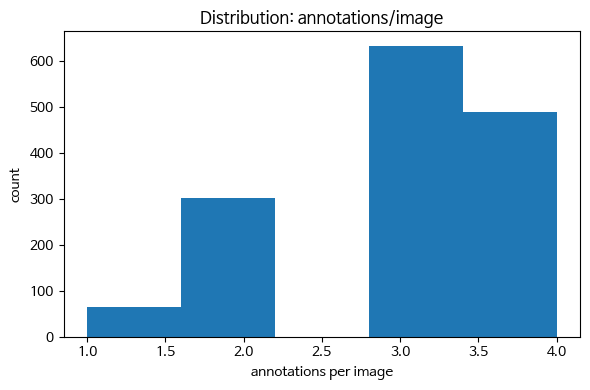

가장 어노가 많은 이미지 Top-10:


,image_id,ann_count
0,1484,4
1,1471,4
2,29,4
3,31,4
4,32,4
5,1459,4
6,1463,4
7,1470,4
8,41,4
9,42,4


In [17]:
# === Cell 6: Ann-per-image distribution ===
per_img = pd.Series(ann_per_img).sort_values(ascending=False)
plt.figure(figsize=(6,4))
plt.hist(per_img.values, bins=min(60, per_img.max()+1))
plt.xlabel("annotations per image")
plt.ylabel("count")
plt.title("Distribution: annotations/image")
plt.tight_layout()
plt.show()

print("가장 어노가 많은 이미지 Top-10:")
top10 = per_img.head(10)
display(pd.DataFrame({"image_id": top10.index, "ann_count": top10.values}))

## 샘플 시각화(무작위 N장 바운딩박스 오버레이)

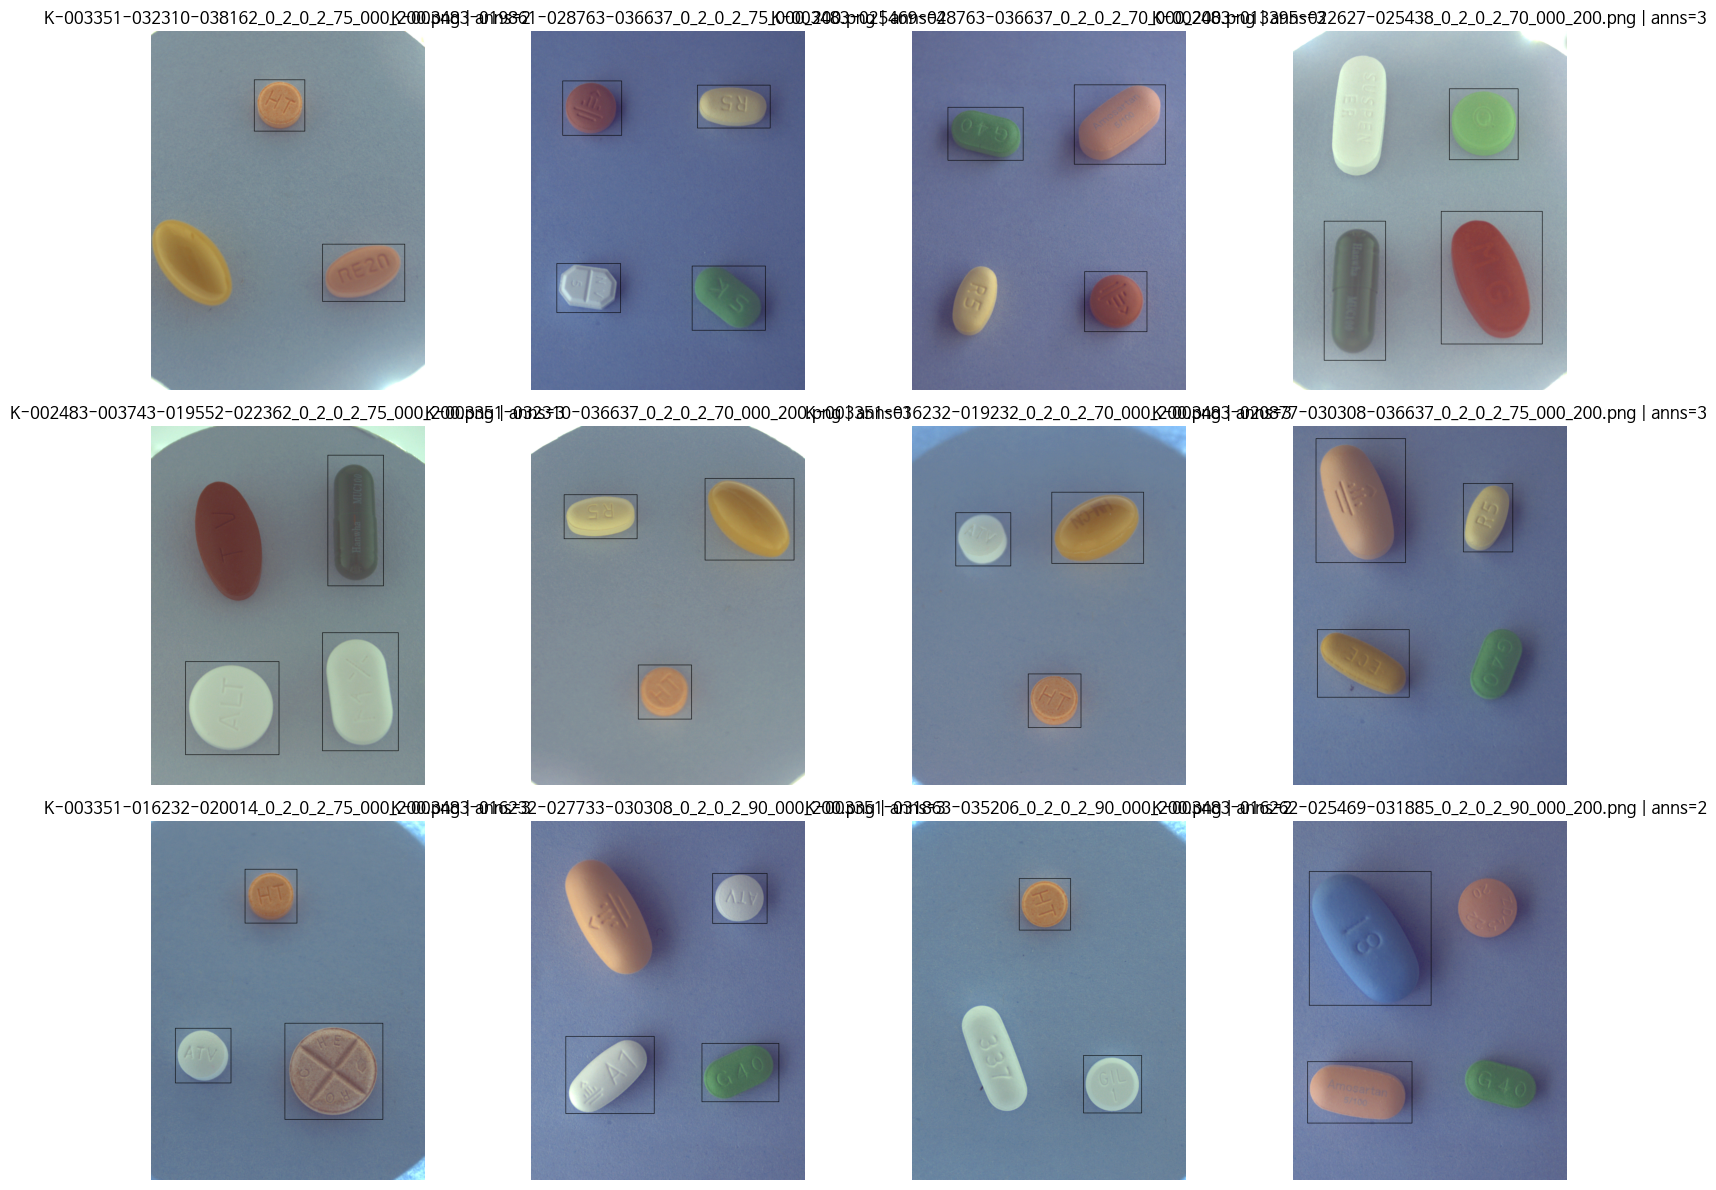

In [18]:
# === Cell 7: Random sample visualization ===
SAMPLES = 12      # 그리고 싶은 이미지 수
COLS    = 4

ids = [im["id"] for im in coco["images"]]
random.shuffle(ids)
ids = ids[:SAMPLES]

plt.figure(figsize=(COLS*4, math.ceil(SAMPLES/COLS)*4))
idx = 1
for iid in ids:
    im = img_by_id[iid]
    fn = Path(im["file_name"]).name
    p = os.path.join(TRAIN_IMG_DIR, fn)
    if not os.path.isfile(p):
        continue
    with Image.open(p).convert("RGB") as pil:
        draw = ImageDraw.Draw(pil)
        anns = [a for a in coco["annotations"] if a["image_id"] == iid]
        for a in anns:
            x,y,w,h = a["bbox"]
            # bbox 그리기(기본 색상/두께)
            draw.rectangle([x,y,x+w,y+h], outline=1, width=2)
        plt.subplot(math.ceil(SAMPLES/COLS), COLS, idx)
        plt.imshow(pil)
        plt.title(f"{fn} | anns={len(anns)}")
        plt.axis("off")
        idx += 1

plt.tight_layout()
plt.show()